In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
from modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
%matplotlib inline

In [17]:
datapath = '../training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'featuresNorbits{0:.1f}Nout{1}trio05/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [18]:
space ={'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.randint ('x_min_child', 20),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [19]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [5]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.5                                                 
ERROR                                               
0.0                                                 
SCORE:                                                        
0.5                                                           
ERROR                                                         
0.0                                                           
SCORE:                                                        
0.9204000000000001                                            
ERROR                                                         
0.0022791036201335285                                         
SCORE:                                                                       
0.9338754400000001                                                           
ERROR                                                                        
0.002225477182480327                              

0.93542232                                                                     
ERROR                                                                          
0.0018276272965225473                                                          
SCORE:                                                                         
0.88658434                                                                     
ERROR                                                                          
0.0032063984177913623                                                          
SCORE:                                                                         
0.9138493999999999                                                             
ERROR                                                                          
0.0021574351545203996                                                          
SCORE:                                                                         
0.9333650600000001                      

In [6]:
best

{'x_learning_rate': 0.1997324656651925,
 'x_max_depth': 19,
 'x_min_child': 5,
 'x_subsample': 0.9214322359721575}

In [7]:
best

{'x_learning_rate': 0.17953937732475247,
 'x_max_depth': 9,
 'x_min_child': 7.0,
 'x_subsample': 0.9827281330982917}

# Would have to set num_boost_round=100 to see the same CV score as in our final fitted model

We're setting n_estimators=100 in model, which is the equivalent of num_boost_round in CV, so if we use the default in CV (10), we will get slightly lower powerformance

In [20]:
model = XGBClassifier(learning_rate = 0.17954, 
                         max_depth = 9, 
                         subsample = 0.9827,
                         min_child_weight = 7)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=200)

[0]	train-auc:0.93606+0.00039	test-auc:0.92146+0.00258
[1]	train-auc:0.94453+0.00046	test-auc:0.92900+0.00208
[2]	train-auc:0.94843+0.00050	test-auc:0.93195+0.00182
[3]	train-auc:0.95096+0.00048	test-auc:0.93407+0.00161
[4]	train-auc:0.95291+0.00046	test-auc:0.93558+0.00153
[5]	train-auc:0.95451+0.00037	test-auc:0.93684+0.00160
[6]	train-auc:0.95599+0.00036	test-auc:0.93801+0.00135
[7]	train-auc:0.95734+0.00032	test-auc:0.93888+0.00125
[8]	train-auc:0.95850+0.00034	test-auc:0.93963+0.00128
[9]	train-auc:0.95945+0.00044	test-auc:0.94024+0.00109
[10]	train-auc:0.96024+0.00033	test-auc:0.94060+0.00103
[11]	train-auc:0.96104+0.00039	test-auc:0.94102+0.00108
[12]	train-auc:0.96166+0.00037	test-auc:0.94135+0.00110
[13]	train-auc:0.96229+0.00035	test-auc:0.94166+0.00112
[14]	train-auc:0.96286+0.00036	test-auc:0.94198+0.00109
[15]	train-auc:0.96344+0.00038	test-auc:0.94237+0.00099
[16]	train-auc:0.96410+0.00034	test-auc:0.94279+0.00104
[17]	train-auc:0.96467+0.00034	test-auc:0.94306+0.00097
[1

[146]	train-auc:0.98867+0.00027	test-auc:0.95034+0.00116
[147]	train-auc:0.98872+0.00030	test-auc:0.95034+0.00116
[148]	train-auc:0.98882+0.00029	test-auc:0.95034+0.00114
[149]	train-auc:0.98888+0.00030	test-auc:0.95036+0.00116
[150]	train-auc:0.98899+0.00031	test-auc:0.95039+0.00118
[151]	train-auc:0.98904+0.00032	test-auc:0.95041+0.00118
[152]	train-auc:0.98913+0.00031	test-auc:0.95043+0.00120
[153]	train-auc:0.98919+0.00034	test-auc:0.95043+0.00120
[154]	train-auc:0.98929+0.00030	test-auc:0.95047+0.00118
[155]	train-auc:0.98938+0.00030	test-auc:0.95048+0.00116
[156]	train-auc:0.98944+0.00027	test-auc:0.95047+0.00114
[157]	train-auc:0.98949+0.00027	test-auc:0.95047+0.00115
[158]	train-auc:0.98958+0.00028	test-auc:0.95052+0.00114
[159]	train-auc:0.98964+0.00030	test-auc:0.95051+0.00113
[160]	train-auc:0.98969+0.00033	test-auc:0.95052+0.00112
[161]	train-auc:0.98974+0.00032	test-auc:0.95054+0.00113
[162]	train-auc:0.98984+0.00030	test-auc:0.95056+0.00111
[163]	train-auc:0.98990+0.00028

In [7]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=200)

[0]	train-auc:0.94918+0.00046	test-auc:0.92091+0.00180
[1]	train-auc:0.95943+0.00087	test-auc:0.92900+0.00200
[2]	train-auc:0.96468+0.00067	test-auc:0.93264+0.00191
[3]	train-auc:0.96846+0.00040	test-auc:0.93490+0.00194
[4]	train-auc:0.97147+0.00041	test-auc:0.93690+0.00179
[5]	train-auc:0.97401+0.00029	test-auc:0.93818+0.00195
[6]	train-auc:0.97620+0.00025	test-auc:0.93911+0.00184
[7]	train-auc:0.97825+0.00034	test-auc:0.94002+0.00176
[8]	train-auc:0.97993+0.00028	test-auc:0.94085+0.00163
[9]	train-auc:0.98149+0.00016	test-auc:0.94174+0.00167
[10]	train-auc:0.98290+0.00016	test-auc:0.94226+0.00161
[11]	train-auc:0.98417+0.00013	test-auc:0.94282+0.00162
[12]	train-auc:0.98531+0.00016	test-auc:0.94323+0.00152
[13]	train-auc:0.98635+0.00018	test-auc:0.94368+0.00152
[14]	train-auc:0.98734+0.00025	test-auc:0.94410+0.00150
[15]	train-auc:0.98816+0.00032	test-auc:0.94452+0.00155
[16]	train-auc:0.98900+0.00029	test-auc:0.94487+0.00155
[17]	train-auc:0.98976+0.00032	test-auc:0.94529+0.00155
[1

[146]	train-auc:0.99987+0.00001	test-auc:0.95087+0.00143
[147]	train-auc:0.99987+0.00001	test-auc:0.95088+0.00142
[148]	train-auc:0.99987+0.00001	test-auc:0.95087+0.00141
[149]	train-auc:0.99987+0.00001	test-auc:0.95089+0.00140
[150]	train-auc:0.99987+0.00001	test-auc:0.95091+0.00142
[151]	train-auc:0.99988+0.00001	test-auc:0.95093+0.00141
[152]	train-auc:0.99988+0.00001	test-auc:0.95094+0.00140
[153]	train-auc:0.99988+0.00001	test-auc:0.95096+0.00139
[154]	train-auc:0.99988+0.00001	test-auc:0.95096+0.00141
[155]	train-auc:0.99988+0.00001	test-auc:0.95096+0.00142
[156]	train-auc:0.99988+0.00001	test-auc:0.95095+0.00141
[157]	train-auc:0.99988+0.00001	test-auc:0.95095+0.00141
[158]	train-auc:0.99989+0.00001	test-auc:0.95094+0.00142
[159]	train-auc:0.99989+0.00001	test-auc:0.95093+0.00142
[160]	train-auc:0.99989+0.00001	test-auc:0.95093+0.00141
[161]	train-auc:0.99989+0.00001	test-auc:0.95093+0.00140
[162]	train-auc:0.99989+0.00001	test-auc:0.95095+0.00140
[163]	train-auc:0.99989+0.00001

In [9]:
model = XGBClassifier(learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         subsample = best["x_subsample"],
                         min_child_weight = best['x_min_child'])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=200)

[0]	train-auc:0.93600+0.00098	test-auc:0.92169+0.00160
[1]	train-auc:0.94423+0.00105	test-auc:0.92884+0.00142
[2]	train-auc:0.94838+0.00076	test-auc:0.93241+0.00115
[3]	train-auc:0.95076+0.00055	test-auc:0.93438+0.00130
[4]	train-auc:0.95268+0.00037	test-auc:0.93580+0.00148
[5]	train-auc:0.95428+0.00042	test-auc:0.93689+0.00133
[6]	train-auc:0.95563+0.00028	test-auc:0.93780+0.00140
[7]	train-auc:0.95707+0.00026	test-auc:0.93868+0.00142
[8]	train-auc:0.95834+0.00024	test-auc:0.93958+0.00138
[9]	train-auc:0.95939+0.00032	test-auc:0.94033+0.00115
[10]	train-auc:0.96026+0.00032	test-auc:0.94075+0.00105
[11]	train-auc:0.96096+0.00038	test-auc:0.94112+0.00102
[12]	train-auc:0.96163+0.00038	test-auc:0.94140+0.00103
[13]	train-auc:0.96228+0.00032	test-auc:0.94187+0.00097
[14]	train-auc:0.96285+0.00030	test-auc:0.94227+0.00091
[15]	train-auc:0.96340+0.00030	test-auc:0.94260+0.00087
[16]	train-auc:0.96399+0.00029	test-auc:0.94294+0.00085
[17]	train-auc:0.96453+0.00031	test-auc:0.94318+0.00091
[1

[146]	train-auc:0.98903+0.00058	test-auc:0.95039+0.00095
[147]	train-auc:0.98907+0.00059	test-auc:0.95037+0.00094
[148]	train-auc:0.98915+0.00059	test-auc:0.95037+0.00093
[149]	train-auc:0.98922+0.00059	test-auc:0.95037+0.00092
[150]	train-auc:0.98933+0.00056	test-auc:0.95041+0.00093
[151]	train-auc:0.98939+0.00058	test-auc:0.95043+0.00093
[152]	train-auc:0.98949+0.00060	test-auc:0.95045+0.00094
[153]	train-auc:0.98956+0.00060	test-auc:0.95045+0.00092
[154]	train-auc:0.98960+0.00062	test-auc:0.95046+0.00092
[155]	train-auc:0.98969+0.00058	test-auc:0.95048+0.00093
[156]	train-auc:0.98979+0.00053	test-auc:0.95048+0.00092
[157]	train-auc:0.98992+0.00055	test-auc:0.95049+0.00094
[158]	train-auc:0.98997+0.00054	test-auc:0.95051+0.00095
[159]	train-auc:0.99004+0.00052	test-auc:0.95051+0.00096
[160]	train-auc:0.99012+0.00052	test-auc:0.95052+0.00096
[161]	train-auc:0.99018+0.00051	test-auc:0.95056+0.00094
[162]	train-auc:0.99026+0.00052	test-auc:0.95059+0.00098
[163]	train-auc:0.99031+0.00050

# dt 0.07

Text(0, 0.5, 'CV AUC score')

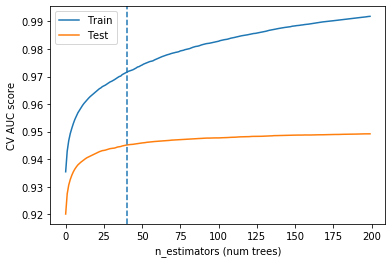

In [12]:
n_estimators = 40
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# dt 0.05

Text(0, 0.5, 'CV AUC score')

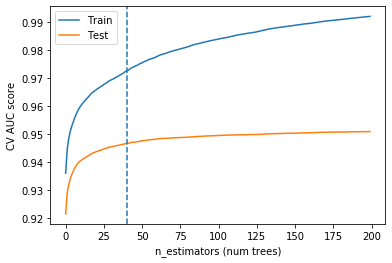

In [21]:
n_estimators = 40
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

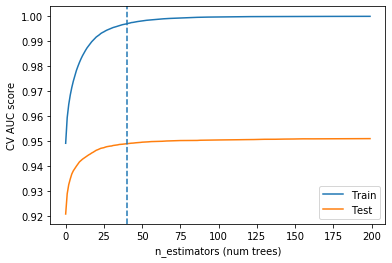

In [8]:
n_estimators = 40
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

Text(0, 0.5, 'CV AUC score')

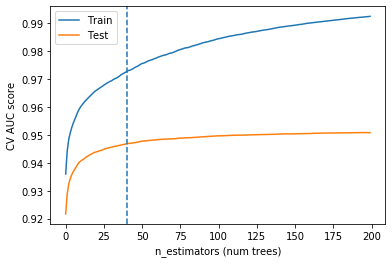

In [11]:
n_estimators = 40
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# Going beyond ~40 trees does not improve the CV score, so cut off training there to avoid overfitting

In [22]:
model.set_params(n_estimators = n_estimators)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.17954, max_delta_step=0, max_depth=9,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=40, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9827,
              tree_method=None, validate_parameters=False, verbosity=None)

In [13]:
model.save_model(datapath+'../spock/models/spock.json')

In [7]:
model = XGBClassifier()
model.load_model(datapath+'../spock/models/spock.json')

# SPOCK

# dt 0.07

Text(0.5, 1.0, 'ROC curve (AUC = 0.948)')

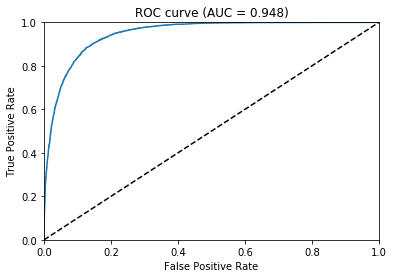

In [14]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# dt 0.05

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

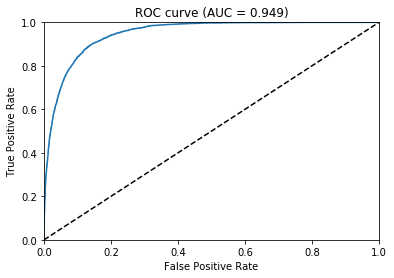

In [23]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'ROC curve (AUC = 0.952)')

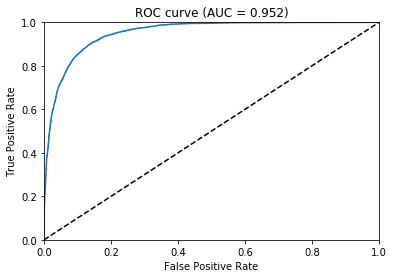

In [10]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

# dt 0.03

Text(0.5, 1.0, 'ROC curve (AUC = 0.949)')

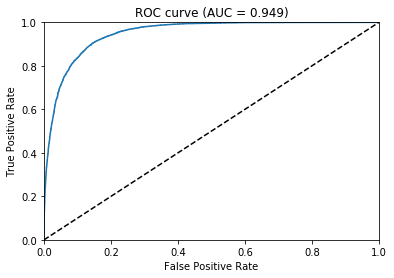

In [8]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [15]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9912655353546143, TPR = 0.0, FPR = 0.0
Threshold 0.9523807764053345, TPR = 0.07873867069486405, FPR = 0.00034457014873944756
Threshold 0.9423768520355225, TPR = 0.1095166163141994, FPR = 0.0007465686556021364
Threshold 0.9341449737548828, TPR = 0.13255287009063443, FPR = 0.0012059955205880664
Threshold 0.926496148109436, TPR = 0.15256797583081572, FPR = 0.0016079940274507552
Threshold 0.9209660291671753, TPR = 0.16824018126888218, FPR = 0.0021248492505599264
Threshold 0.9143182039260864, TPR = 0.18731117824773413, FPR = 0.002526847757422615
Threshold 0.9054248332977295, TPR = 0.21204682779456194, FPR = 0.0029862746224085454
Threshold 0.8979172706604004, TPR = 0.2320619335347432, FPR = 0.003388273129271234
Threshold 0.8929848074913025, TPR = 0.24754531722054382, FPR = 0.003790271636133923
Threshold 0.8872196078300476, TPR = 0.2626510574018127, FPR = 0.004249698501119853
Threshold 0.8832286596298218, TPR = 0.2722809667673716, FPR = 0.004709125366105783
Threshold 0.87829768657

In [9]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))

Threshold 1.9917409420013428, TPR = 0.0, FPR = 0.0
Threshold 0.947735071182251, TPR = 0.09554380664652568, FPR = 0.00028714179061620627
Threshold 0.93668532371521, TPR = 0.12669939577039274, FPR = 0.0006891402974788951
Threshold 0.9324690103530884, TPR = 0.14029456193353473, FPR = 0.0012059955205880664
Threshold 0.922663152217865, TPR = 0.17163897280966767, FPR = 0.0016079940274507552
Threshold 0.9158943891525269, TPR = 0.18976586102719034, FPR = 0.0020674208924366853
Threshold 0.9094080328941345, TPR = 0.21015861027190333, FPR = 0.002469419399299374
Threshold 0.9037584066390991, TPR = 0.2271525679758308, FPR = 0.0029862746224085454
Threshold 0.9003922343254089, TPR = 0.23659365558912387, FPR = 0.003388273129271234
Threshold 0.8962094187736511, TPR = 0.2471676737160121, FPR = 0.003847699994257164
Threshold 0.8909737467765808, TPR = 0.26000755287009064, FPR = 0.004249698501119853
Threshold 0.8865716457366943, TPR = 0.2688821752265861, FPR = 0.0046516970079825415
Threshold 0.881961941719

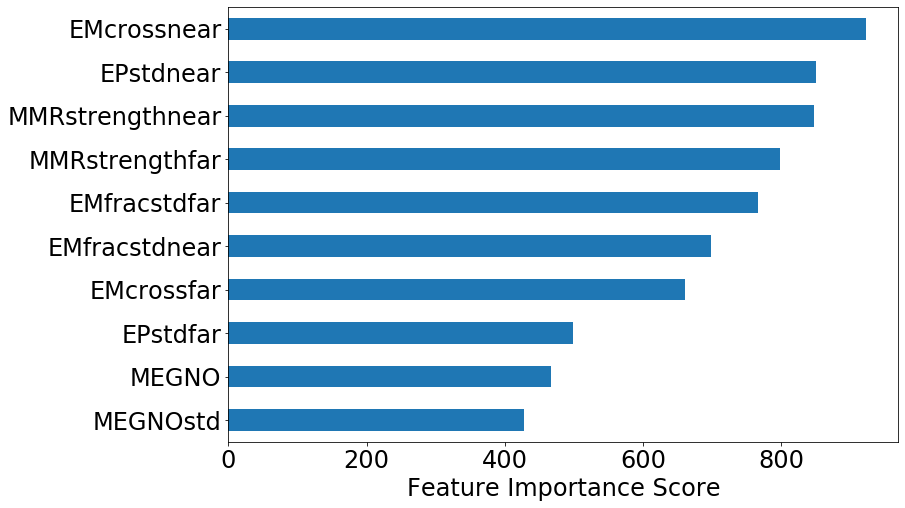

In [16]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

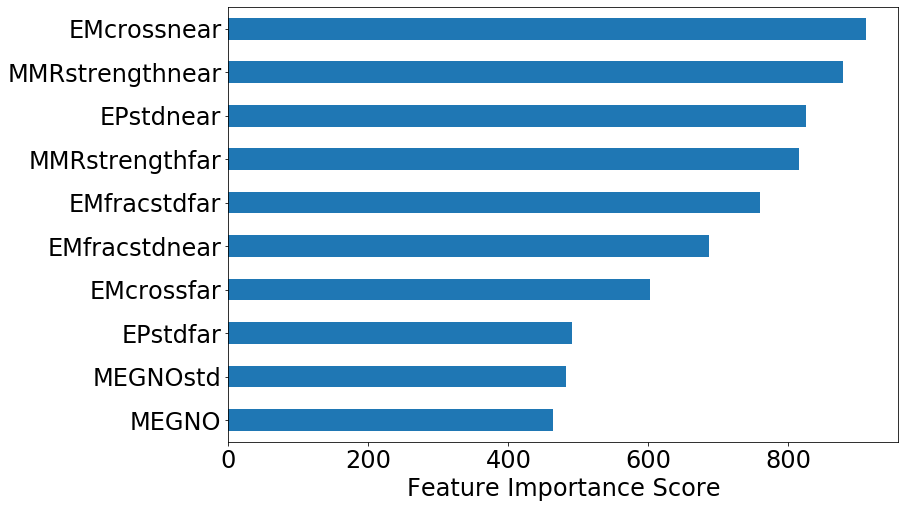

In [10]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

(0, 328.90000000000003)

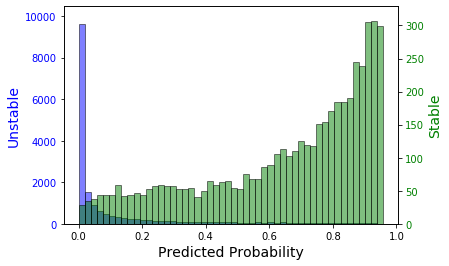

In [19]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,35*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

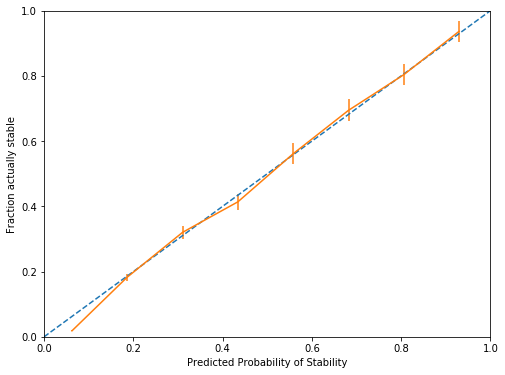

In [12]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=8)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

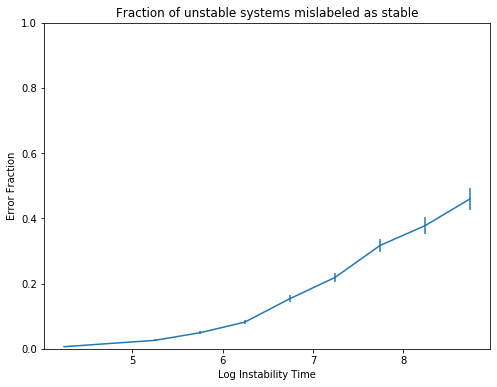

In [14]:
thresh = 0.35 # for 10% FPR
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, thresh, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')